In [1]:
from pint import UnitRegistry
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [125]:
class TwoQueTwoSer():

    def __init__(self, lam, mu):
        self.left_crowd = 0
        self.right_crowd = 0
        self.lam = lam
        self.mu = mu
        self.data = {'minute':[0], 'left_crowd':[0], 'right_crowd':[0]}

    # check if a customer enter
    def customer_enter(self):
        if np.random.uniform() > (1-self.lam):
            return True
    
    # distribuite the queue choice based on the least crowded
    def in_line(self):
        if self.right_crowd > self.left_crowd:
            self.left_crowd += 1
        else:
            self.right_crowd += 1
    
    # probability of successful check
    def check_out(self):
        if self.right_crowd > 0:
            if np.random.uniform() > (1-self.mu):
                self.right_crowd -= 1
        if self.left_crowd > 0:
            if np.random.uniform() > (1-self.mu):
                self.left_crowd -= 1    
    
    def run_simulation(self, n):
        for _ in range(n):
            if self.customer_enter():
                self.in_line()
            self.check_out()

            self.data['minute'].append(self.data['minute'][-1] + 1)
            self.data['left_crowd'].append(self.left_crowd)
            self.data['right_crowd'].append(self.right_crowd)

        print(self.right_crowd, self.left_crowd)

In [126]:
lam = 1/2 #probability of a customer entering per minute
mu = 1/5

model = TwoQueTwoSer(lam, mu)

In [127]:
model.run_simulation(100)

3 2


In [128]:
class OneQueOneSer():

    def __init__(self, lam, mu):
        self.crowd = 0
        self.lam = lam
        self.mu = mu*2 if mu <0.5 else 0.9
        self.data = {'minute':[0], 'crowd':[0]}
    
    # check if a customer enter
    def customer_enter(self):
        if np.random.uniform() > (1-self.lam):
            self.crowd += 1
    
    # probability of successful check
    def check_out(self):
        if self.crowd > 0:
            if np.random.uniform() > (1-self.mu):
                self.crowd -= 1 

    def run_simulation(self, n):
        for _ in range(n):
            self.customer_enter()
            self.check_out()

            self.data['minute'].append(self.data['minute'][-1] + 1)
            self.data['crowd'].append(self.crowd)

        print(self.crowd)

In [129]:
model2 = OneQueOneSer(lam, mu)

In [130]:
model2.run_simulation(100)

11


c:\Users\matte\anaconda3\envs\py_env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\matte\anaconda3\envs\py_env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\matte\anaconda3\envs\py_env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\matte\anaconda3\envs\py_env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future ver

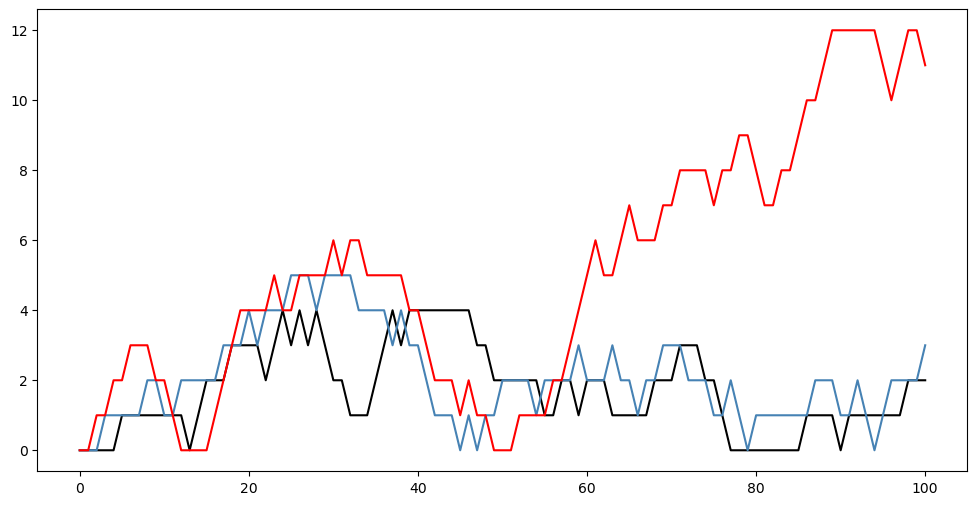

In [131]:
fig, ax = plt.subplots(figsize=(12,6))

sns.lineplot(x=model.data['minute'], y=model.data['left_crowd'], color='black', ax=ax)
sns.lineplot(x=model.data['minute'], y=model.data['right_crowd'], color='steelblue', ax=ax)
sns.lineplot(x=model2.data['minute'], y=model2.data['crowd'], color='red', ax=ax);